In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder

In [6]:
matdata = loadmat('Data/Lab 4/ex4data1.mat')
weights = loadmat('Data/Lab 4/ex4weights.mat')

In [25]:
theta0 = weights['Theta1']
theta1 = weights['Theta2']
print(theta0.shape, theta1.shape)

X, Y = matdata['X'], matdata['y']
Y = Y.reshape(len(X))
print(X.shape, Y.shape)

encoder = OneHotEncoder(categories='auto')
Y_OH = encoder.fit_transform(matdata['y']).toarray()
print(Y_OH.shape)

(25, 401) (10, 26)
(5000, 400) (5000,)
(5000, 10)


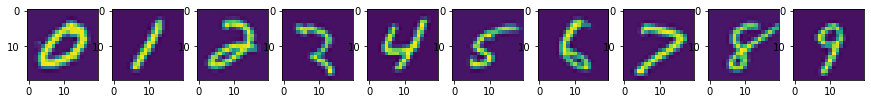

In [26]:
DIG_MAP = { digit: y_val for digit, y_val in zip(range(10), Y[::500]) }
IMGAGES = matdata['X'].reshape(len(X), 20, 20)

fig, axs = plt.subplots(1, 10, figsize=(15,15))
for digit in sorted(DIG_MAP):
    start, end = digit*500, (digit+1)*500
    img = IMGAGES[start:end][50]
    axs[digit].imshow(img.T)

In [46]:
def activation_func(z):
    """ Parameters
        ----------
        z: array, shape (any)
        
        Returns
        -------
        g(z): array, shape (any)
    """
    return 1 / (1 + np.exp(-z))



def h_func(theta0, theta1, x):
    """ Parameters
        ----------
        x:      array, shape (m, n_a0)
        theta0: array, shape (n_a1, n_a0)
        theta1: array, shape (n_a2, n_a1)
        
        Returns
        -------
        h(Θ, x): array, shape (n_out)
    """
    m, n = x.shape
    a_0 = np.c_[np.ones(m), x]

    a_1 = activation_func(a_0.dot(theta0.T))
    a_1 = np.c_[np.ones(m), a_1]

    a_2 = activation_func(a_1.dot(theta1.T))
    return a_2


def J_func(theta0, theta1, x, y, *, λ):
    """
        Parameters
        ----------
        x:      array, shape (m, n_a0)
        theta0: array, shape (n_a1, n_a0)
        theta1: array, shape (n_a2, n_a1)
        y:      array, shape (m, )
        λ:      number
        
        Returns
        -------
        J(Θ): number
    """
    m, _ = x.shape

    h_Θx = h_func(theta0, theta1, x)
    J_value = -(y*np.log(h_Θx) + (1-y)*np.log(1-h_Θx)).sum() / m
    
    L2 = 0
    if λ != 0:
        for i in range(len(Θ)):
            L2 += (Θ[i]**2).sum()
        L2 *= λ/(2*m)
    
    return J_value + L2

In [69]:
def forward_propagation(Θ, x):
    """
        Parameters
        ----------
        Θ: array of Θ matrix
        x: array, shape (n_in, )
        
        Returns
        -------
        a: List[np.array], shape (n_out, n_in)
    """
    N_L = len(Θ)
    
    a_zero = np.ones(1)
    a = [None] * (N_L + 1)

    a_in = x
    for i in range(N_L):
        a_in = np.concatenate((a_zero, a_in))
        a[i] = a_in
        a_out = get_a_out(Θ[i], a_in)
        a_in = a_out

    a[-1] =  a_out   
    return a  


def back_propagation(Θ, x, y, *, λ):
    """
        Parameters
        ----------
        Θ: tuple of Θ matrix
        x: array, shape (m, n)
        y: array, shape (m, n_categories)
        
        Returns
        -------
        D: array, shape == Θ[i].shape
    """
    m = len(x)
    N_L = len(Θ) + 1

    Δ = np.array([np.zeros(θ.shape) for θ in Θ])
    D = np.array([np.zeros(θ.shape) for θ in Θ])
    
    for t in range(0, m):
        a = forward_propagation(Θ, x[t])
        
        δ = [None] * N_L
        δ[N_L-1] = a[N_L-1] - y[t]
        
        for l in range(N_L-2, 0, -1):
            δ[l] = Θ[l].T.dot(δ[l+1]) * a[l]*(1-a[l])
    
        for l, _ in enumerate(Δ):
            delta = δ[l+1]
            if l != len(Δ) - 1:
                delta = delta[1:]
            delta = np.vstack(delta)
            al = np.vstack(a[l]).T
            Δ[l] +=  delta.dot(al)
            
    for l, _ in enumerate(Δ):
        for (i, j), Δlij in np.ndenumerate(Δ[l]):
            if j != 0:
                D[l][i, j] = (Δlij + λ*Θ[l][i, j]) / m
            else:
                D[l][i, j] = Δlij / m        
    return D


def to_number(h_array):
    """ 
        Parameters
        ----------
        h: array, shape (Θ[-1].n_out, )
        
        Returns
        -------
        number: 0, 1, .. 8, 9
    """
    return h_array.argmax(axis=1) + 1


def gradient_check(Θ, x, y, *, λ, ϵ):
    """
        Parameters
        ----------
        Θ: tuple of Θ matrix
        x: array, shape (m, n)
        y: array, shape (m, n_categories)
        λ: number
        ϵ: number
        
        Returns
        -------
        D: array, shape == Θ[i].shape
    """
    D_expected = np.array([np.zeros(θ.shape) for θ in Θ])
    for l, _ in enumerate(Θ):
        for (i, j), Θlij in np.ndenumerate(Θ[l]):
            theta = Θ[l][i, j]
            
            Θ[l][i, j] = theta + ϵ
            J_plus = J_func(Θ[0], Θ[1], x, y, λ=λ)

            Θ[l][i, j] = theta - ϵ
            J_minus = J_func(Θ[0], Θ[1], x, y, λ=λ)
            
            D_expected[l][i,j] =(J_plus - J_minus) / (2*ϵ)
            
            Θ[l][i][j] = theta
    return D_expected


def gradient_descent(theta0, theta1, x, y, *, λ, ϵ, α):
    """
        Parameters
        ----------
        Θ: tuple of Θ matrix
        x: array, shape (m, n)
        y: array, shape (m, n_categories)
        λ: number
        ϵ: number
        
        Returns
        -------
        Θ: tuple of Θ matrix
    """    
    for i in range(120):
        print(i, 'α = ', α)
        D = back_propagation((theta0, theta1), x, y, λ=λ)
        
        theta0_new = theta0 - α * D[0]
        theta1_new = theta1 - α * D[1]

        J_Θ = J_func(theta0, theta1, x, y, λ=λ)
        J_Θ_new = J_func(theta0, theta1, x, y, λ=λ)
        ΔJ = J_Θ - J_Θ_new
        if ΔJ < 0:
            print("ΔJ < 0")
            α /= 3
            continue
        elif ΔJ < ϵ:
            print("ΔJ < ϵ")
        elif ΔJ < 10**(-2):
            α *= 3
            print("ΔJ < 0.01")
            
        theta0 = theta0_new
        theta1 = theta1_new

    print(i)
    return theta0, theta1

In [70]:
h_value = h_func(theta0, theta1, X)
y = to_number(h_value)

(y == Y).mean()

0.9752

In [71]:
ϵ = 10**(-8)
λ = 0
theta0_rand = np.random.rand(*theta0.shape)* 2 * 0.12 - 0.12
theta1_rand = np.random.rand(*theta1.shape)* 2 * 0.12 - 0.12

In [72]:
Θ_new = gradient_descent(theta0_rand, theta1_rand, X, Y_OH, λ=λ, ϵ=ϵ, α=3)

0 α =  3
ΔJ < ϵ
1 α =  3
ΔJ < ϵ
2 α =  3
ΔJ < ϵ
3 α =  3
ΔJ < ϵ
4 α =  3
ΔJ < ϵ
5 α =  3
ΔJ < ϵ
6 α =  3
ΔJ < ϵ
7 α =  3
ΔJ < ϵ
8 α =  3
ΔJ < ϵ
9 α =  3
ΔJ < ϵ
10 α =  3
ΔJ < ϵ
11 α =  3
ΔJ < ϵ
12 α =  3
ΔJ < ϵ
13 α =  3
ΔJ < ϵ
14 α =  3
ΔJ < ϵ
15 α =  3
ΔJ < ϵ
16 α =  3
ΔJ < ϵ
17 α =  3
ΔJ < ϵ
18 α =  3
ΔJ < ϵ
19 α =  3
ΔJ < ϵ
20 α =  3
ΔJ < ϵ
21 α =  3
ΔJ < ϵ
22 α =  3
ΔJ < ϵ
23 α =  3
ΔJ < ϵ
24 α =  3
ΔJ < ϵ
25 α =  3
ΔJ < ϵ
26 α =  3
ΔJ < ϵ
27 α =  3
ΔJ < ϵ
28 α =  3
ΔJ < ϵ
29 α =  3
ΔJ < ϵ
30 α =  3
ΔJ < ϵ
31 α =  3
ΔJ < ϵ
32 α =  3
ΔJ < ϵ
33 α =  3
ΔJ < ϵ
34 α =  3
ΔJ < ϵ
35 α =  3
ΔJ < ϵ
36 α =  3
ΔJ < ϵ
37 α =  3
ΔJ < ϵ
38 α =  3
ΔJ < ϵ
39 α =  3
ΔJ < ϵ
40 α =  3
ΔJ < ϵ
41 α =  3
ΔJ < ϵ
42 α =  3
ΔJ < ϵ
43 α =  3
ΔJ < ϵ
44 α =  3
ΔJ < ϵ
45 α =  3
ΔJ < ϵ
46 α =  3
ΔJ < ϵ
47 α =  3
ΔJ < ϵ
48 α =  3
ΔJ < ϵ
49 α =  3
ΔJ < ϵ
50 α =  3
ΔJ < ϵ
51 α =  3
ΔJ < ϵ
52 α =  3
ΔJ < ϵ
53 α =  3
ΔJ < ϵ
54 α =  3
ΔJ < ϵ
55 α =  3
ΔJ < ϵ
56 α =  3
ΔJ < ϵ
57 α =  3
ΔJ < ϵ
58 α =  3
ΔJ < ϵ
59 α = 

In [75]:
(to_number(h_func(Θ_new[0], Θ_new[1], X)) == Y).mean()

0.6852

In [ ]:
from itertools import product

fig, axs = plt.subplots(5, 5, figsize=(10,10))
idxs = product(range(5), range(5))
        
for idx in idxs:
    i0, i1 = idx
    i = 5 * i0 + i1
    img = Θ_new[0][i][1:].reshape(20, 20)
    axs[i0][i1].imshow(img)

In [ ]:
# from typing import NamedTuple
# from pprint import pprint

# class Error(NamedTuple):
#     l: int
#     i: int
#     j: int
#     D_backpropag: float
#     D_aproximate: float

# errors = []
# for l, _ in enumerate(D):
#     for (i, j), _ in np.ndenumerate(D[l]):
#         if j == 0: 
#             continue
#         if abs(D[l][i, j] - D_expected[l][i, j]) >= ϵ:
#             err = Error(l, i, j, D[l][i, j],  D_expected[l][i, j])
#             errors.append(err)
# pprint(errors)

In [ ]:
theta0 = Θ1 
theta1 = Θ2
x = X

m, n = x.shape
a_0 = np.c_[np.ones(m), x]

a_1 = a_0.dot(theta0.T)
a_1 = np.c_[np.ones(m), a_1]

a_2 = a_1.dot(theta1.T)

a_2.shape

(25, 401)